### Import libraries and data

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('data/unique_outages2.csv', parse_dates=['Start', 'Finish', 'file_name'])
df['Duration_Category'].value_counts()

Duration_Category
11.0–14.0 hrs    649
20.8+ hrs        558
9.5–11.0 hrs     525
2.8–9.5 hrs      395
0–2.8 hrs        114
14.0–20.8 hrs     30
Name: count, dtype: int64

### Function for model training 

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

def train_and_evaluate_rf(df, use_ensemble=False, train_model=True, model=None, test_size=0.2, random_state=42):
    """
    Train and evaluate a Random Forest model, optionally using an ensemble of models.
    
    Args:
        df: Pandas DataFrame with features and target
        use_ensemble: Whether to use an ensemble model (VotingClassifier)
        train_model: Whether to train the model
        model: The model to be used (if not training a new one)
        test_size: Proportion of the data to be used as test data
        random_state: Random seed for reproducibility
        
    Returns:
        Trained model and evaluation results
    """

    # --- 1. Select Features and Target
    features = ['Recall_Day_Hours', 'Recall_Night_Hours', # numerical columns
                'Project Work?', 'DNSP Aware?', 'Generator Aware?', 'Inter-Regional', # boolean columns
                'Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description' # categorical columns
                ] 
    target = 'Duration_Category'

    X = df[features].copy()
    y = df[target]

    # --- 2. Encode Categorical Features
    for col in ['Region', 'NSP', 'Asset Type', 'Reason', 'Status_Code', 'Status_Description']:
        X[col] = LabelEncoder().fit_transform(X[col])

    # --- 3. Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # --- 4. Train Model (if needed)
    if train_model or model is None:
        if use_ensemble:
            rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=random_state)
            svc = SVC(probability=True, kernel='rbf')
            logreg = LogisticRegression(max_iter=1000)

            # Create a VotingClassifier ensemble
            model = VotingClassifier(
                estimators=[
                    ('rf', rf),
                    ('svc', svc),
                    ('logreg', logreg)
                ],
                voting='soft'  # Use probability-based averaging
            )
            model.fit(X_train, y_train)
        else:
            model = RandomForestClassifier(random_state=random_state)
            model.fit(X_train, y_train)

    # --- 5. Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # --- 6. Accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # --- 7. Get present labels (classes that actually exist)
    full_label_order = [
        '0–2.8 hrs',
        '2.8–9.5 hrs',
        '9.5–11.0 hrs',
        '11.0–14.0 hrs',
        '14.0–20.8 hrs',
        '20.8+ hrs'
    ]
    present_labels = [label for label in full_label_order if label in y_test.unique()]

    # --- 8. Classification Report
    print("Classification Report (Test Set):")
    print(classification_report(y_test, y_test_pred, labels=present_labels, target_names=present_labels))

    # --- 9. Visualization
    fig = plt.figure(figsize=(18, 16))
    gs = gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1])

    # --- Feature Importances (Only for RandomForest, not for ensemble)
    if not use_ensemble:
        ax0 = fig.add_subplot(gs[0, :])
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        feature_names = X.columns

        ax0.barh(np.array(feature_names)[indices], importances[indices], color='goldenrod')
        ax0.invert_yaxis()
        ax0.set_title("Feature Importances")
        ax0.set_xlabel("Importance")

    # --- Confusion Matrices (Include all classes, even those with 0 occurrences)
    cm_train = confusion_matrix(y_train, y_train_pred, labels=full_label_order)
    cm_test = confusion_matrix(y_test, y_test_pred, labels=full_label_order)
    
    ax1 = fig.add_subplot(gs[1, 0])
    disp_train = ConfusionMatrixDisplay(cm_train, display_labels=full_label_order)
    disp_train.plot(ax=ax1, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
    ax1.set_title(f"Train Confusion Matrix (Acc: {train_acc:.2%})")

    ax2 = fig.add_subplot(gs[1, 1])
    disp_test = ConfusionMatrixDisplay(cm_test, display_labels=full_label_order)
    disp_test.plot(ax=ax2, cmap='viridis', xticks_rotation=45, values_format='d', colorbar=False)
    ax2.set_title(f"Test Confusion Matrix (Acc: {test_acc:.2%})")

    # --- Duration Category Distributions (Show all classes, even if count is 0)
    train_categories = y_train.value_counts().sort_index()
    test_categories = y_test.value_counts().sort_index()

    # Ensure all classes are included, even if count is 0
    train_counts = train_categories.reindex(full_label_order, fill_value=0)
    test_counts = test_categories.reindex(full_label_order, fill_value=0)

    ax3 = fig.add_subplot(gs[2, 0])
    ax3.bar(train_counts.index, train_counts.values, color='darkcyan')
    ax3.set_title("Train Set Duration Category Distribution")
    ax3.set_xlabel("Duration Category")
    ax3.set_ylabel("Count")
    ax3.tick_params(axis='x', rotation=45)

    ax4 = fig.add_subplot(gs[2, 1])
    ax4.bar(test_counts.index, test_counts.values, color='slateblue')
    ax4.set_title("Test Set Duration Category Distribution")
    ax4.set_xlabel("Duration Category")
    ax4.set_ylabel("Count")
    ax4.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    return model  # Return model for possible reuse

### Import function for model evaluation

/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.70      0.33      0.45        21
  2.8–9.5 hrs       0.82      0.70      0.75        83
 9.5–11.0 hrs       0.60      0.75      0.66       106
11.0–14.0 hrs       0.74      0.73      0.73       126
14.0–20.8 hrs       0.00      0.00      0.00         5
    20.8+ hrs       0.85      0.87      0.86       114

     accuracy                           0.74       455
    macro avg       0.62      0.56      0.58       455
 weighted avg       0.74      0.74      0.73       455



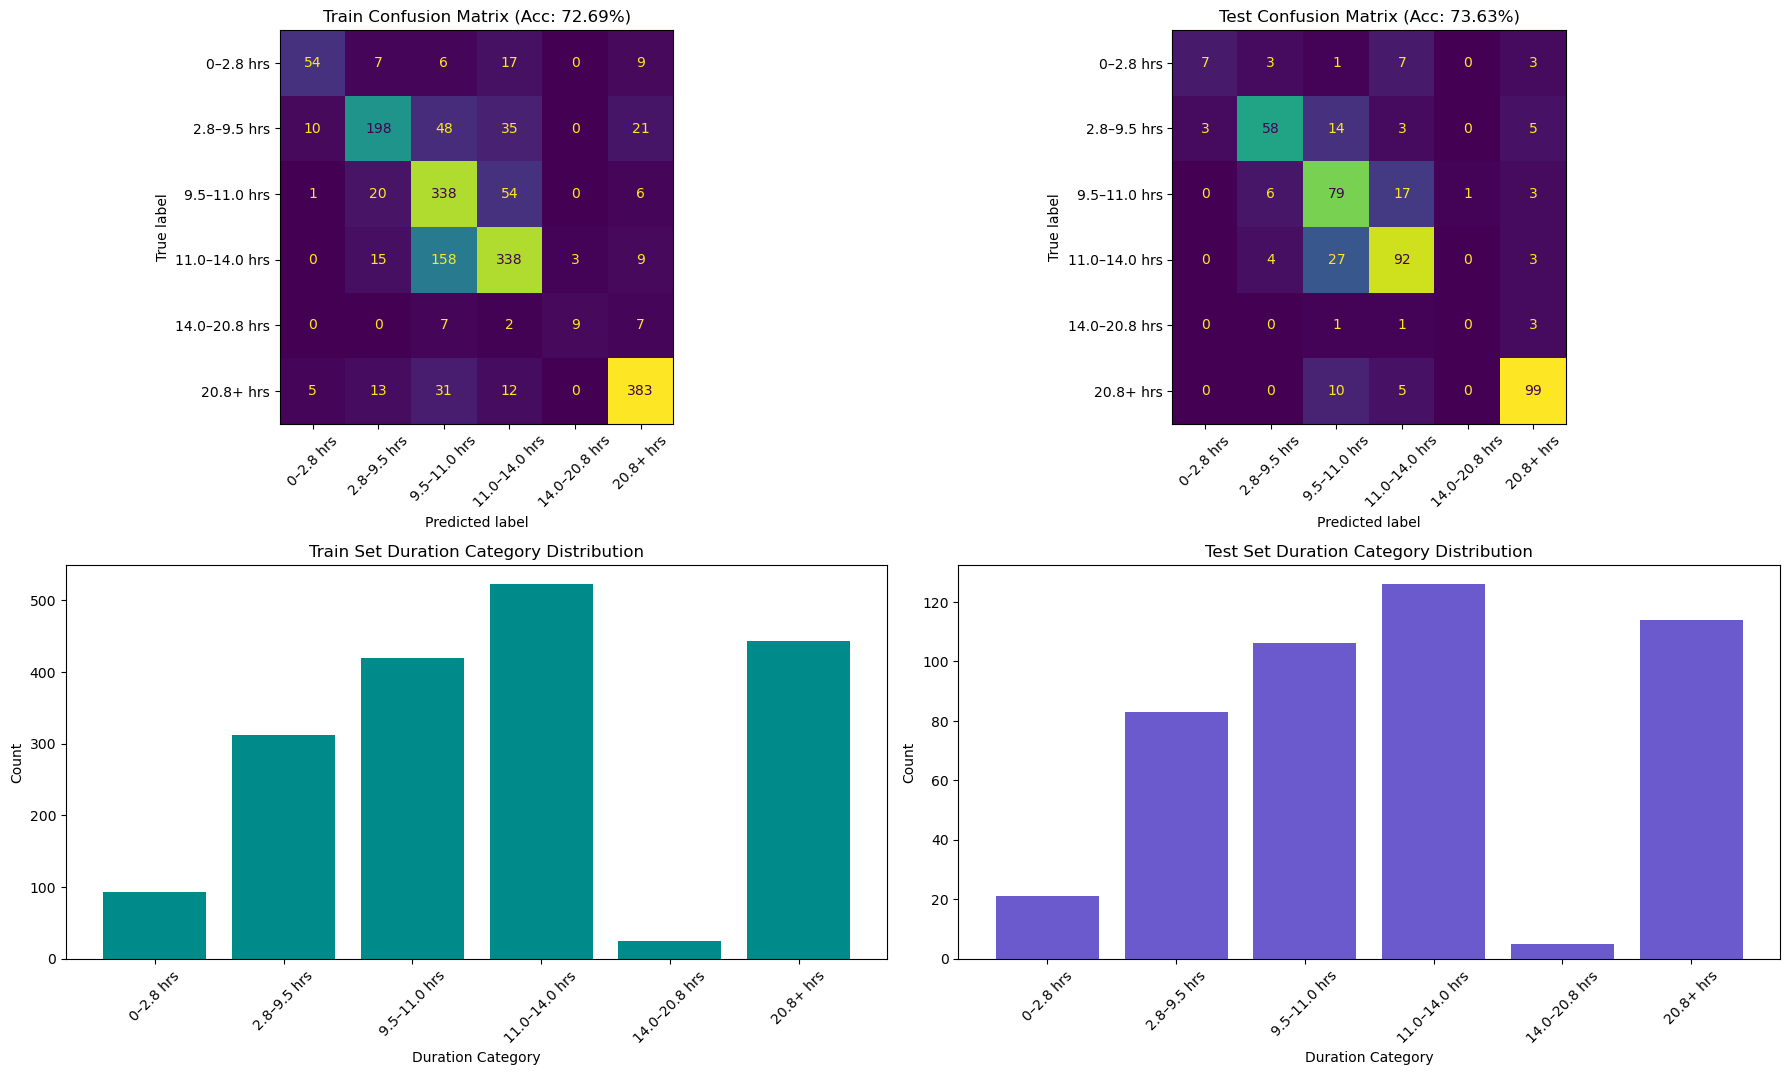

In [7]:
model = train_and_evaluate_rf(df, use_ensemble=True)

### Model fitting on state-specific data

--- Evaluating for Region: SA ---
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       1.00      1.00      1.00         3
  2.8–9.5 hrs       0.75      0.75      0.75         8
 9.5–11.0 hrs       0.00      0.00      0.00         1
11.0–14.0 hrs       0.67      0.50      0.57         4
14.0–20.8 hrs       0.00      0.00      0.00         2
    20.8+ hrs       0.90      1.00      0.95        38

     accuracy                           0.88        56
    macro avg       0.55      0.54      0.55        56
 weighted avg       0.82      0.88      0.85        56



/opt/conda/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

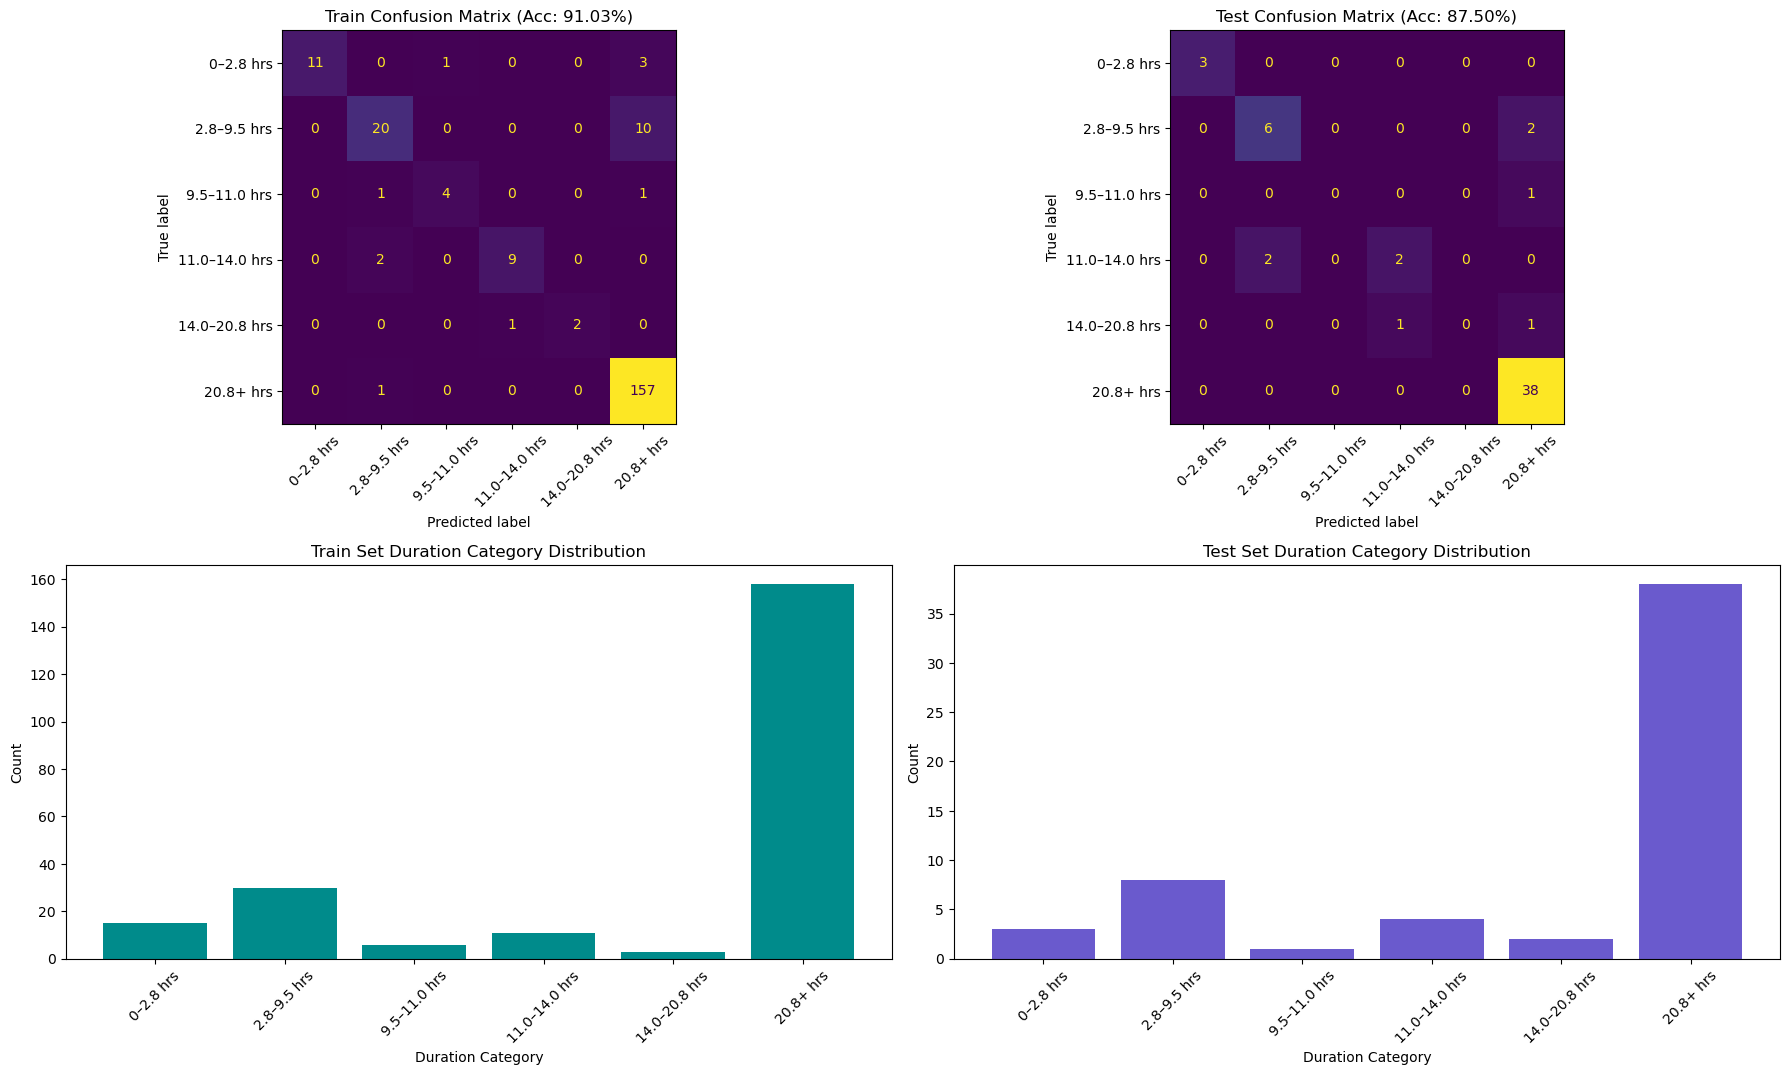

--- Evaluating for Region: VIC ---
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.00      0.00      0.00         6
  2.8–9.5 hrs       0.75      0.16      0.26        19
 9.5–11.0 hrs       0.53      0.80      0.64        79
11.0–14.0 hrs       0.74      0.70      0.72       119
14.0–20.8 hrs       0.00      0.00      0.00         3
    20.8+ hrs       0.67      0.40      0.50        20

     accuracy                           0.64       246
    macro avg       0.45      0.34      0.35       246
 weighted avg       0.64      0.64      0.61       246



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


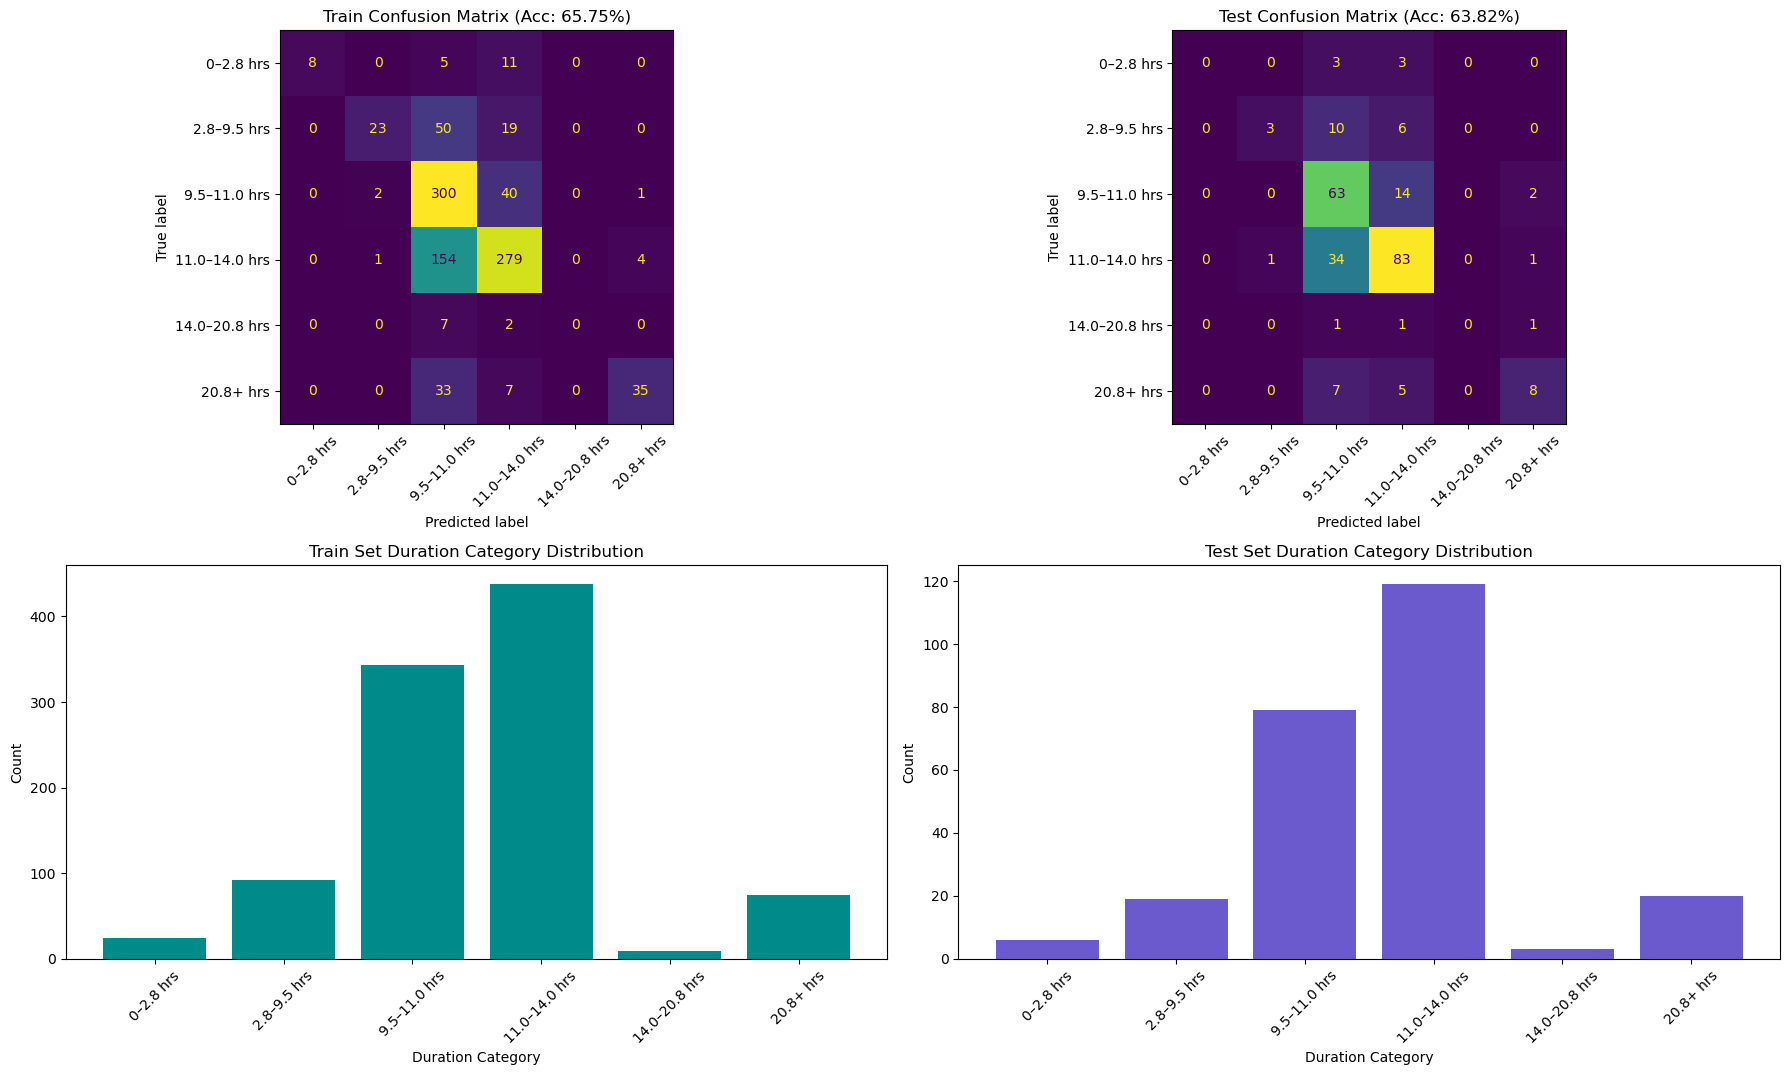

--- Evaluating for Region: TAS ---
Classification Report (Test Set):
              precision    recall  f1-score   support

   0–2.8 hrs       0.40      0.33      0.36         6
 2.8–9.5 hrs       0.65      0.79      0.71        14
   20.8+ hrs       0.75      0.43      0.55         7

   micro avg       0.62      0.59      0.60        27
   macro avg       0.60      0.52      0.54        27
weighted avg       0.62      0.59      0.59        27



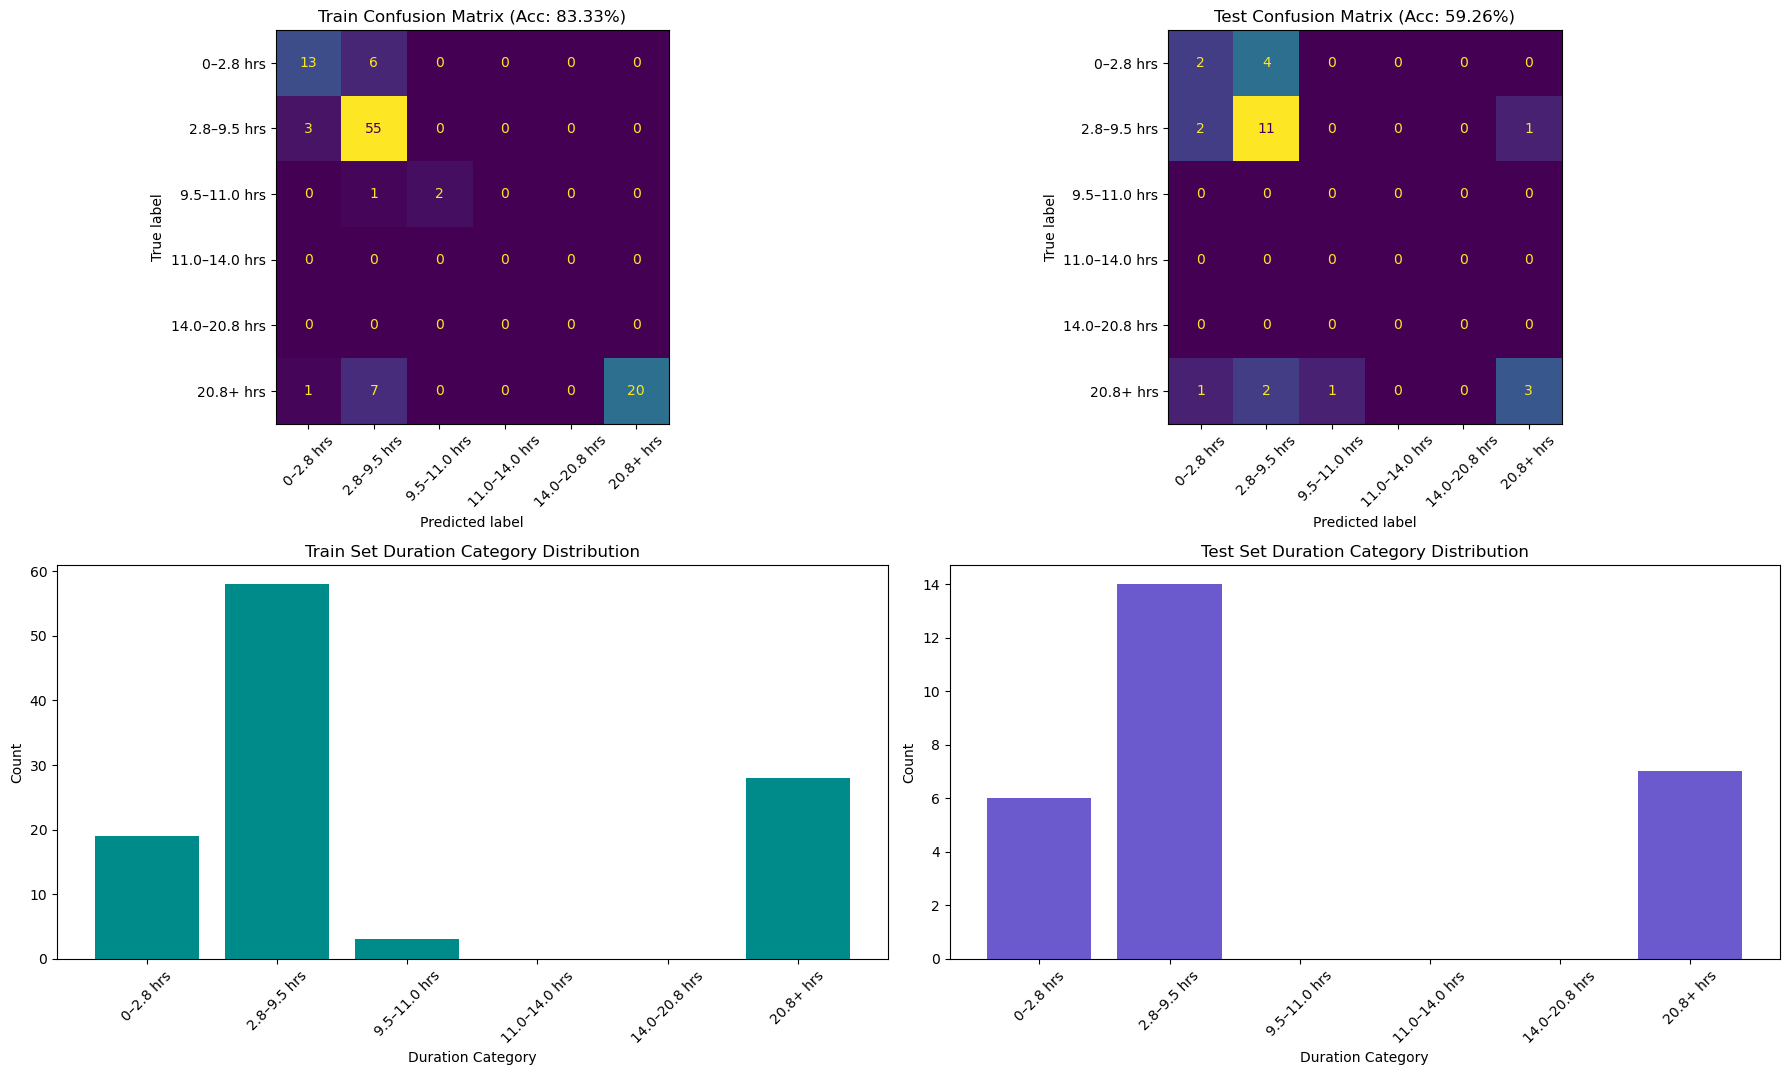

--- Evaluating for Region: QLD ---
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.50      0.50      0.50         6
  2.8–9.5 hrs       0.93      0.79      0.86        34
 9.5–11.0 hrs       1.00      1.00      1.00         1
11.0–14.0 hrs       0.00      0.00      0.00         3
    20.8+ hrs       0.76      0.97      0.85        29

     accuracy                           0.81        73
    macro avg       0.64      0.65      0.64        73
 weighted avg       0.79      0.81      0.79        73



/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


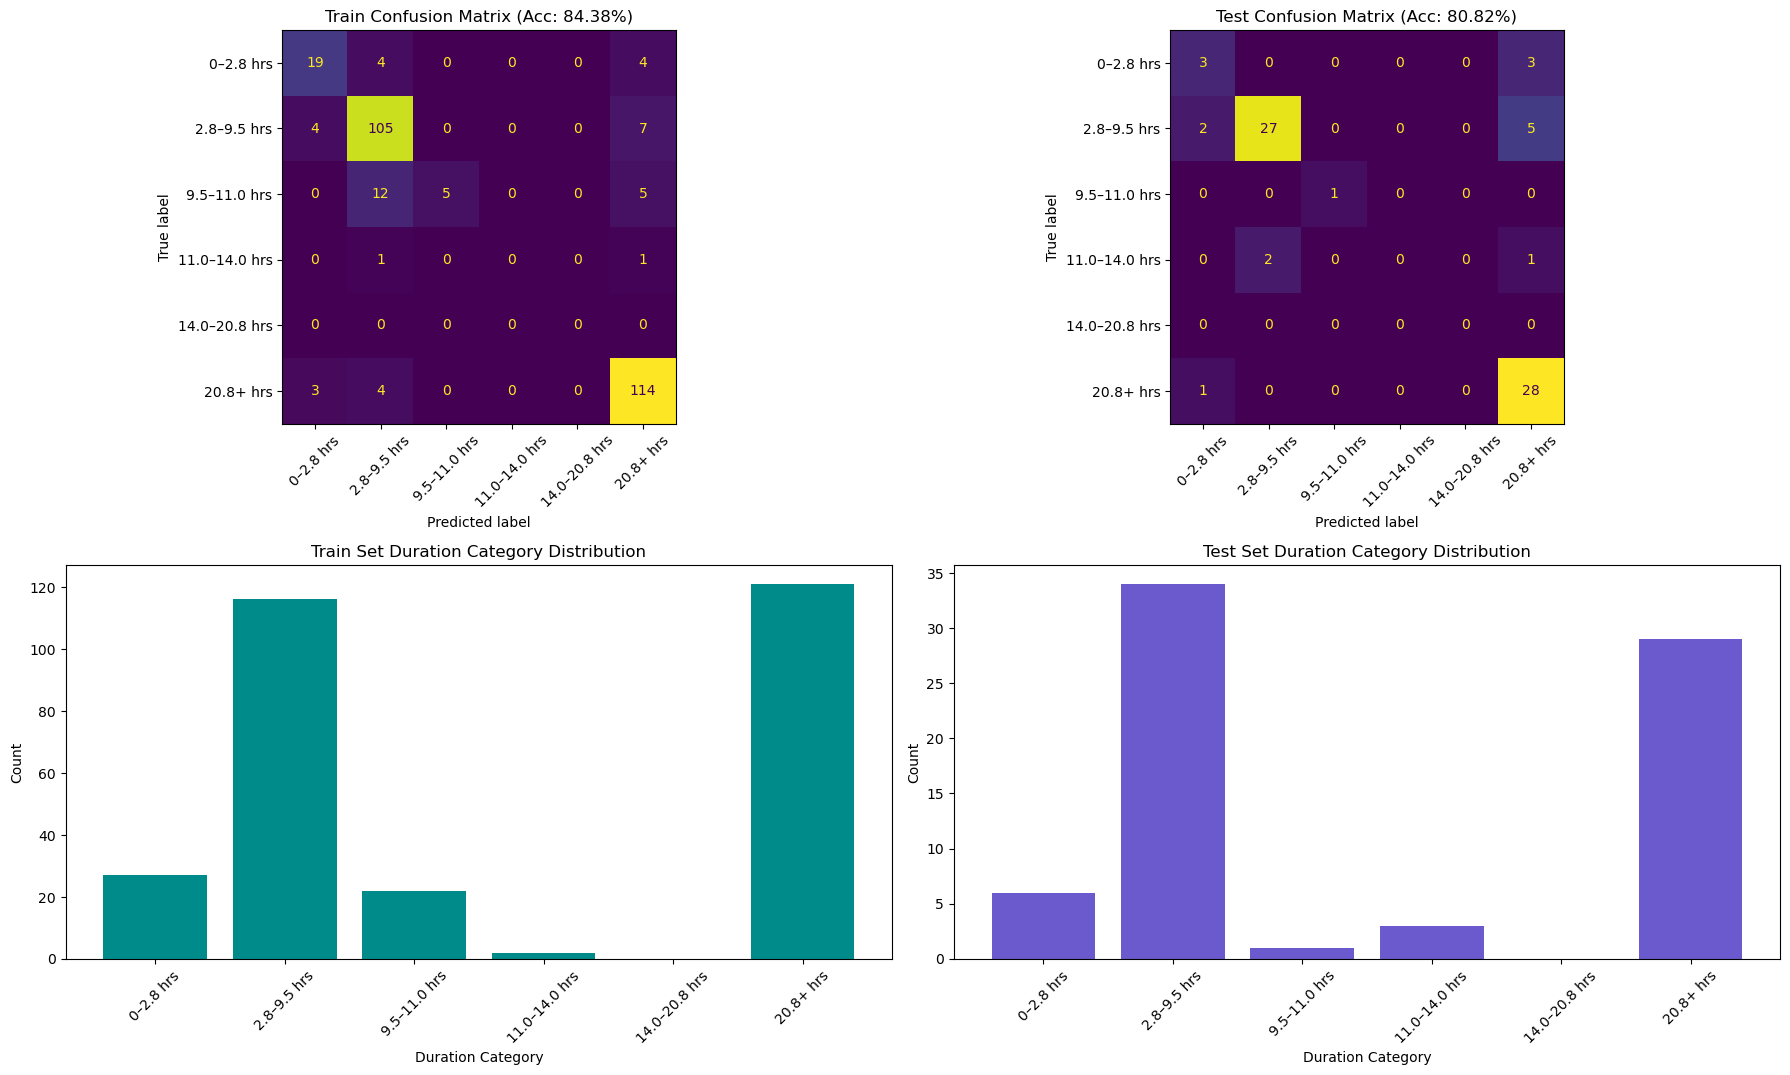

--- Evaluating for Region: NSW ---
Classification Report (Test Set):
               precision    recall  f1-score   support

    0–2.8 hrs       0.33      0.50      0.40         2
  2.8–9.5 hrs       0.00      0.00      0.00         5
 9.5–11.0 hrs       0.72      0.76      0.74        17
11.0–14.0 hrs       0.67      0.77      0.71        13
14.0–20.8 hrs       1.00      0.50      0.67         2
    20.8+ hrs       0.88      0.93      0.90        15

     accuracy                           0.72        54
    macro avg       0.60      0.58      0.57        54
 weighted avg       0.68      0.72      0.70        54



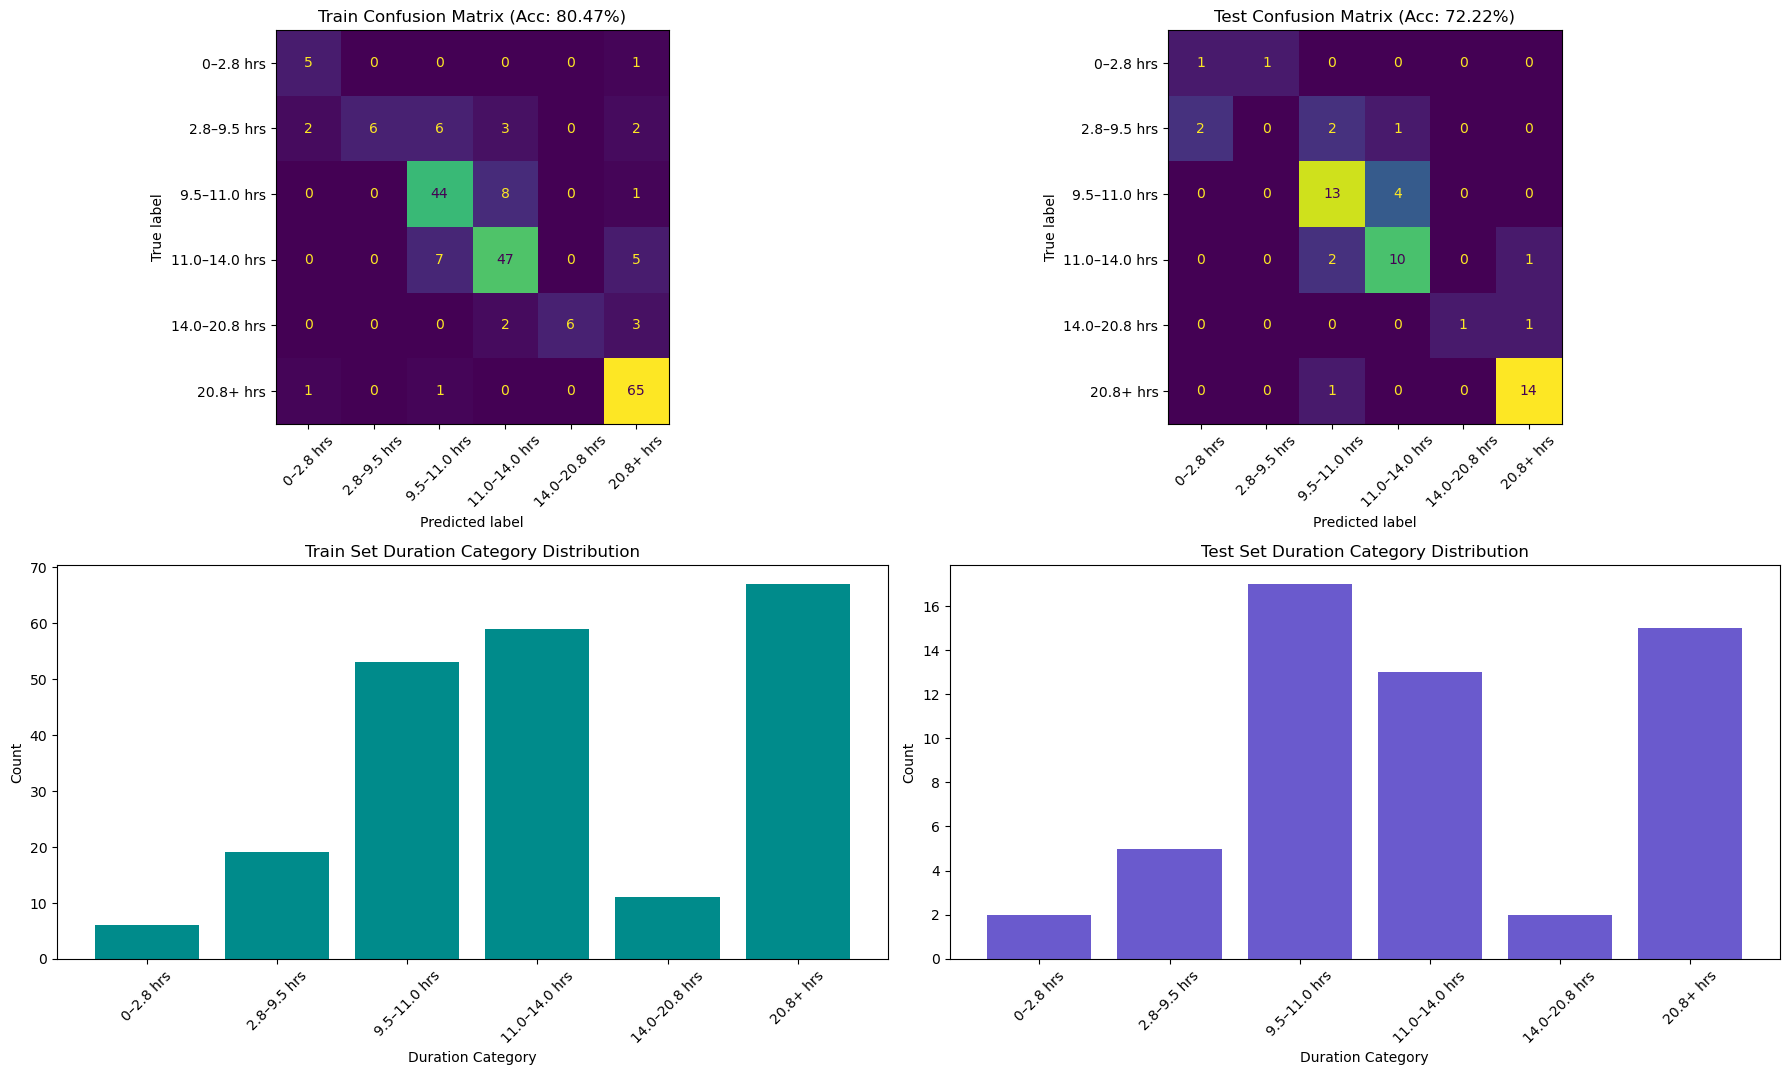

In [8]:
# Create an empty dictionary to store the models for each region
region_models = {}

# Iterate over each unique region
for region in df['Region'].unique():
    # Filter the dataset for the current region
    region_df = df[df['Region'] == region].copy()
    
    print(f"--- Evaluating for Region: {region} ---")
    
    # Train and evaluate the model for the current region
    model = train_and_evaluate_rf(region_df, use_ensemble=True, train_model=True)
    
    # Store the trained model for the current region
    region_models[region] = model